In [1]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/GaussFit_spec2D.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py

%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/KLens


In [2]:
data_info = gen_dataInfo_from_tfCube(redshift=0.2, vcirc=200., sini=0.8, g1=0.05, slitAngles=[0.0])

redshift : 0.2
g1 : 0.05
half_light_radius : 0.5
vcirc : 200.0
sini : 0.8
slitWidth : 0.02
slitAngles : [0.0]


returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)
total tfCube time: 4.6476781368255615 (sec)
total getSlitSpectra time: 1.1754000186920166 (sec)


In [3]:
data_info['par_fid']

{'g1': 0.05,
 'g2': 0.0,
 'sini': 0.8,
 'diskFrac': 1.0,
 'n_knots': 10.0,
 'knot_fraction': 0.0,
 'aspect': 0.2,
 'vcirc': 200.0,
 'sigma_intr': 0.01,
 'redshift': 0.2,
 'half_light_radius': 0.5,
 'vscale': 0.5,
 'r_0': 0.0,
 'V_0': 0.0,
 'linelist': array([('OIIa', 372.7092, 2.e-25), ('OIIb', 372.9875, 2.e-25),
        ('OIIIa', 496.0295, 2.e-25), ('OIIIb', 500.824 , 2.e-25),
        ('Halpha', 656.461 , 6.e-24)],
       dtype=[('species', '<U16'), ('lambda', '<f8'), ('flux', '<f8')]),
 'norm': 1e-26,
 'abs_magnitude': None,
 'image_size': 128,
 'ngrid': 256,
 'psfFWHM': 0.5,
 'psf_g1': 0.0,
 'psf_g2': 0.0,
 'area': 785000.0,
 'pixScale': 0.032,
 'Resolution': 5000,
 'lambda_min': array([785.7532]),
 'lambda_max': array([789.7532]),
 'nm_per_pixel': 0.025,
 'gain': 1.0,
 'read_noise': 3.0,
 'throughput': 0.78,
 'expTime': 10000.0,
 'type_of_observation': 'slit',
 'fiber_size': 1.0,
 'fiber_offsets': [[0.0, 0.0],
  [1.0, 0.0],
  [-1.0, 0.0],
  [0.0, 1.0],
  [1.0, 1.0]],
 'slitAngles':

2D spec dimension: (256, 256, 160)
image dimension: (128, 128)
image variance: 3.257167583111905e-08


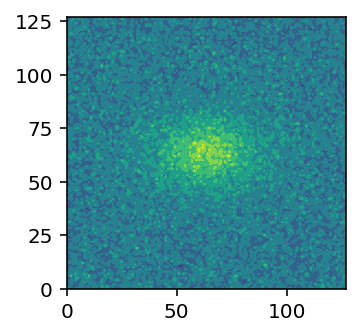

In [4]:
# dimension setting
print("2D spec dimension:", data_info['ModelCube'].shape)
print("image dimension:", data_info['image'].shape)
print("image variance:", data_info['image_variance'])

# check image
fig, ax = plt.subplots(1,1, figsize=(2.5,2.5))
ax.contourf(data_info['image'])

# Image 

In [5]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ImageFit.py

In [6]:
ImageFit = ImageFit(data_info=data_info)

In [7]:
# check : data model consistency 
model_image = ImageFit.model_image(e_obs=1, half_light_radius=0.5)

print("data signal", ImageFit.image[63,63])
print("model signal", model_image[63,63])

data signal 0.0005844569
model signal 0.00074318505


In [8]:
chainImage_info = ImageFit.run_MCMC(Nwalker=50, Nsteps=1000)

100%|██████████| 1000/1000 [01:26<00:00, 11.54it/s]

Total MCMC time (mins): 1.4452512343724568


In [9]:
Chain_Image = ChainTool(chainImage_info, Nburn=30000, Nend=50000)

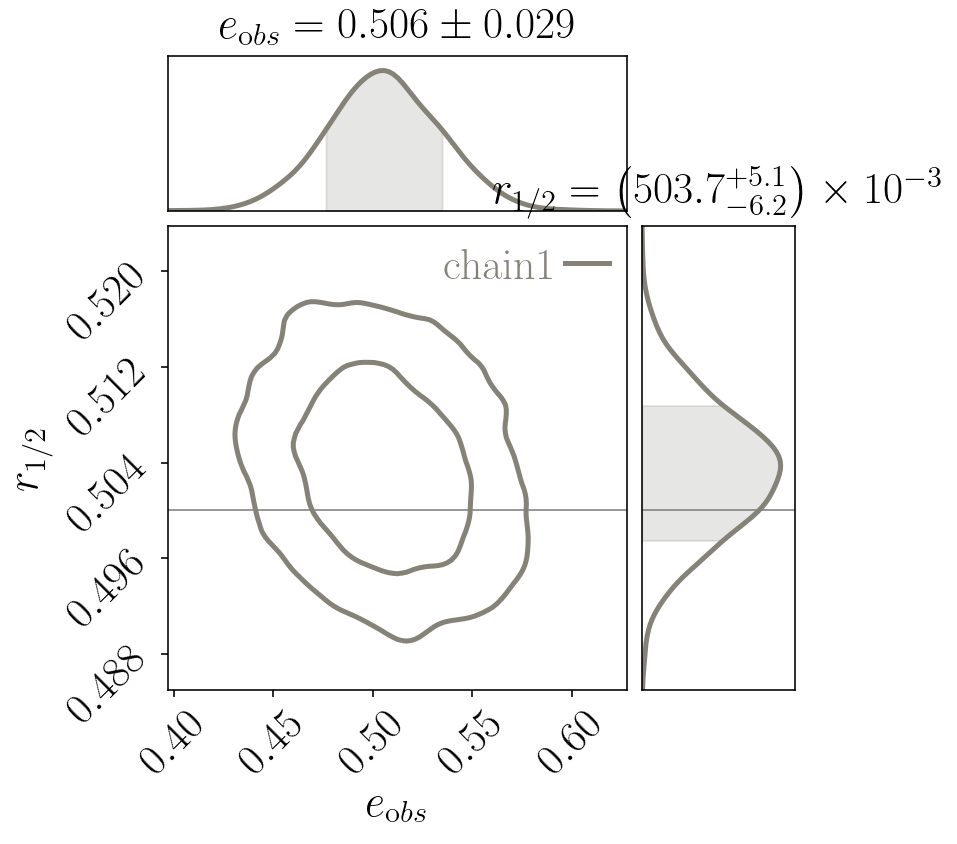

In [10]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['e_obs','half_light_radius']

parID1,parName1,par_x1 = Chain_Image.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain_Image.chain[:, parID1], parameters=parName1 ,name="$\mathrm{chain1}$")


c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=22,tick_font_size=22
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)


c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=[None,0.5]) #, truth=par_x1

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

In [11]:
bestfit_e_obs = Chain_Image.par_bestfit(select_par_key=['e_obs'], statistics='max')['e_obs'][1]
bestfit_e_obs

0.5057746689380945

# 2D spectrum

In [12]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/RotationCurveFit.py

In [13]:
# init Fit tool
RotFit = RotationCurveFit(data_info, active_par_key = ['vscale','vcirc','sini'], e_obs=bestfit_e_obs)

time cost in gaussFit_spec2D: 0.3811941146850586 (secs)


In [14]:
# find fitting parameter using optimizer
params_rot = RotFit.optFit_rotation_curve(RotFit.gaussfit_peakLambda)
params_rot

{'vscale': 0.49871697621885414,
 'r_0': -9.999999999999999e-09,
 'vcirc': 200.0513511251338,
 'v_0': -8.160874620692622e-22,
 'redshift': 0.19999999999999998,
 'sini': 0.8000329922916445}

In [15]:
# find fitting parameters using MCMC (get error bars as well)
chain_info = RotFit.run_MCMC(Nwalker=100, Nsteps=3000)

/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 3000/3000 [00:26<00:00, 113.24it/s]


Total MCMC time (mins): 0.4418089509010315


In [16]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py
Chain = ChainTool(chain_info, Nburn=150000, Nend=300000)

In [17]:
Chain.chain.shape

(150000, 6)

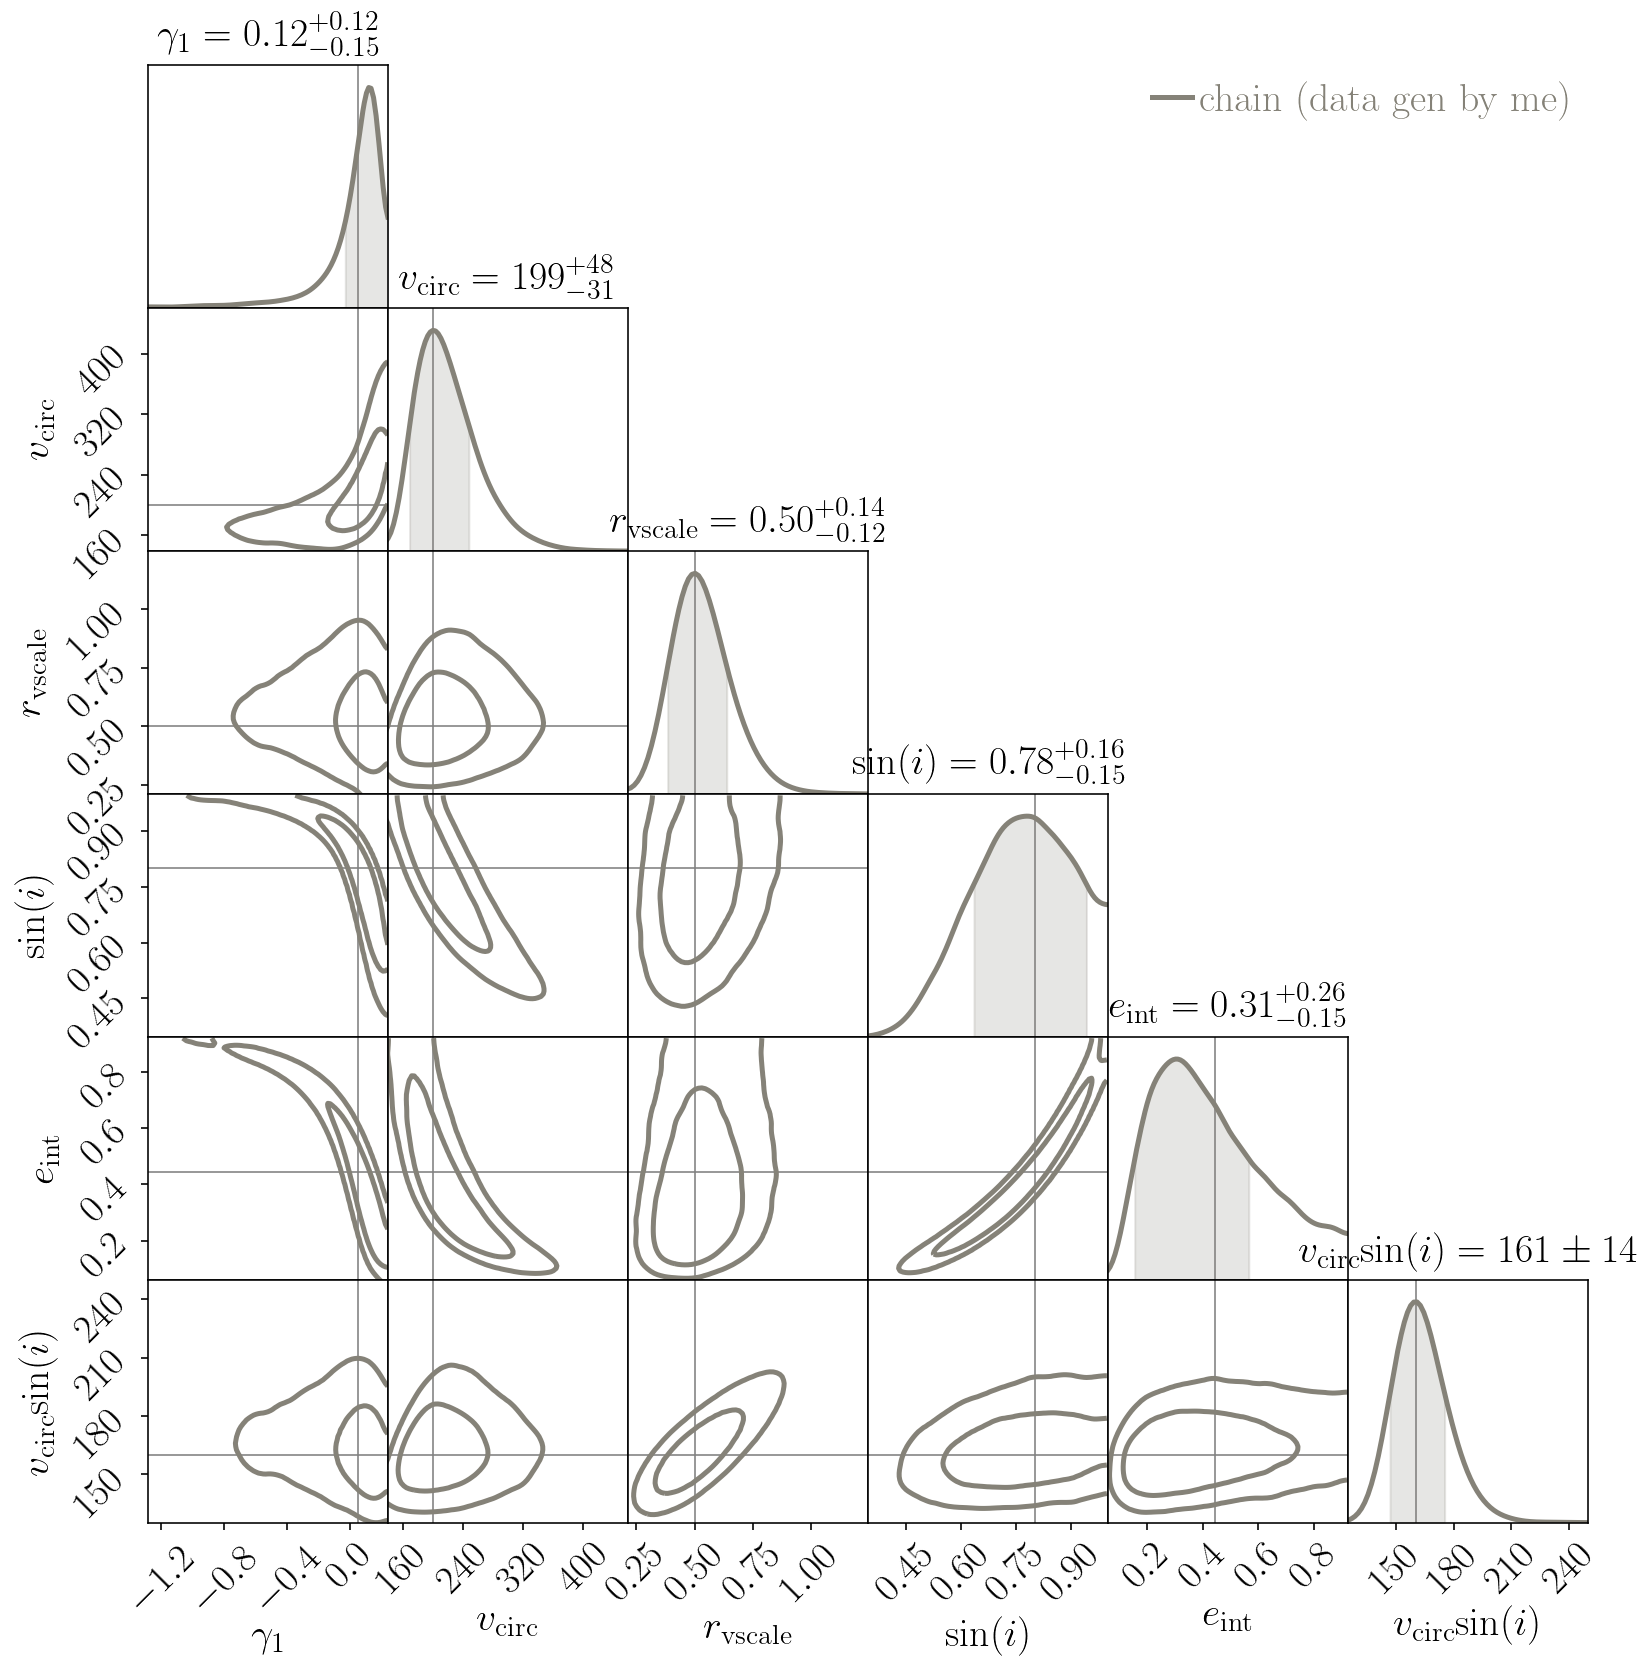

In [18]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['g1','vcirc','vscale','sini','e_int','vsini']

parID1,parName1,par_x1 = Chain.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain.chain[:, parID1]       , parameters=parName1 ,name="$\mathrm{chain\ (data\ gen\ by\ me)}$")


c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=20,tick_font_size=20
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)


c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
fig = c.plotter.plot(legend=True, truth=par_x1)

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2.5 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

# ---- END ----

In [19]:
import emcee
import numpy as np

def log_prior(params):
    return -0.5 * np.sum(params**2)

def log_like(params):
    return -0.5 * np.sum((params / 0.1)**2)

def log_prob(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf, -np.inf
    ll = log_like(params)
    if not np.isfinite(ll):
        return lp, -np.inf
    return lp + ll, lp

coords = np.random.randn(32, 3)
nwalkers, ndim = coords.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
sampler.run_mcmc(coords, 100)

log_prior_samps = sampler.get_blobs()
flat_log_prior_samps = sampler.get_blobs(flat=True)

print(log_prior_samps.shape)  # (100, 32)
print(flat_log_prior_samps.shape)  # (3200,)

(100, 32)
(3200,)


In [20]:
log_prior_samps.shape

(100, 32)

In [21]:
sampler.get_last_sample().coords

array([[ 5.99191849e-02,  5.73458748e-02, -7.49365643e-02],
       [ 1.30587622e-01, -3.60730069e-02, -9.35969193e-02],
       [-1.79421877e-01, -5.77390043e-02,  4.74268144e-02],
       [-4.94636661e-02,  1.11727651e-01,  2.49306183e-02],
       [ 8.81357346e-03, -7.66222672e-02, -1.25058327e-01],
       [ 1.11712449e-01, -3.30518294e-02,  1.10364443e-01],
       [-3.33131427e-02, -1.71588357e-01, -1.52411937e-01],
       [ 1.45435809e-01,  1.41894025e-01, -8.99938733e-02],
       [-7.15473935e-04,  6.57327325e-02, -5.99538111e-02],
       [-2.79702795e-02, -8.69953720e-02, -1.39866982e-01],
       [-1.73682818e-02, -6.57612174e-02, -1.07121219e-01],
       [ 3.49811463e-02,  2.48687338e-01, -5.37745356e-02],
       [-2.32677358e-02, -5.71837878e-02,  8.72982128e-02],
       [ 1.04244963e-01,  3.03398717e-02, -1.16927316e-01],
       [-5.60587775e-02, -1.00757453e-01, -4.08909074e-02],
       [ 1.24697849e-01,  2.60578500e-01, -5.56105478e-02],
       [-3.41930728e-02,  4.97841153e-02